# Model Factory

In [1]:
import os, sys, math, datetime, csv
import psutil

# import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import (
    Input,
    Dense,
    Flatten,
    Conv2D,
    Dropout,
    Reshape,
    DepthwiseConv2D,
    MaxPooling2D,
    AvgPool2D,
    GlobalAveragePooling2D,
    Softmax,
    BatchNormalization,
    Concatenate,
)
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#from dotenv import load_dotenv

# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model

from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths, get_file_size, create_model_name, append_dict_to_csv

import wandb
from wandb.keras import WandbCallback

# import deeplake

In [2]:
models_dir = initialize()

# Define the model

In [109]:

img_res = 96
channels = 1

classes = 3
alpha = 0.05
dropout_rate = 0.5

In [110]:
input_shape = (img_res,img_res,channels)

In [111]:
model_stats = {"img_res" : img_res,
    "classes" : classes,
    "channels" : channels,
    "alpha" : alpha,
    "dropout_rate" : dropout_rate,
    }

In [112]:
def mobilenet_v1(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
    """
    This function builds a CNN model according to the MobileNet V1 specification, using the functional API.
    The function returns the model.
    """

    # MobileNet V1 Block
    def mobilenet_v1_block(x, filters, strides):
        # Depthwise convolution
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same")(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters=filters, kernel_size=1, strides=1)(
            x
        )  # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        return x

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=32 * alpha, kernel_size=3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_v1_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=512 * alpha, strides=2)

    for _ in range(loop_depth):  # TODO: reduce the depth of the net for faster inference
        x = mobilenet_v1_block(x, filters=512 * alpha, strides=1)

    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=1)

    if global_average_pooling:  
        x = GlobalAveragePooling2D(keepdims=True)(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1)(x)
        x = Reshape((1,classes))(x)
        outputs = Softmax()(x)


    else:
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=7, strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
        outputs = Dense(units=classes, activation="softmax")(x)  # TODO: is there a stride=1 implementation in Dense?

    model = Model(inputs=inputs, outputs=outputs, name="mobilenetv1")

    return model

In [113]:
model = mobilenet_v1(input_shape, classes=classes, alpha=alpha)

In [114]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(
    input_shape=input_shape,
    alpha=alpha,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights=None, #'imagenet'
    input_tensor=None,
    pooling=None,
    classes=classes,
    classifier_activation='softmax',
    #**kwargs
)


In [115]:
#model = mobilenet
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [116]:
# Show model in local version of Netron.app
view_model(model, tflite=True, build=True)

Serving 'C:/Users/Susanne/AppData/Local/Temp/Susanne/mltk/tmp_models/model.h5' at http://localhost:8080
Stopping http://localhost:8080


In [117]:
# Create the model name
base_model_name = model.name
variation_code = "000"  # code for special tweaks on the model
#variation_code = "keras"  # code for special tweaks on the model


In [118]:
model_name = create_model_name(base_model_name, alpha, input_shape, classes, variation_code)
print(model_name)

mobilenet_0.05_96_0.05_96_c1_o3_keras


In [119]:
model_stats["model_name"] = model_name

In [120]:
# Create the filepath structure
(
    models_path,
    models_summary_path,
    models_image_path,
    models_layer_df_path,
    models_tf_path,
    models_tflite_path,
    models_tflite_opt_path,
) = create_filepaths(model_name)

# mobilenet_v1 = keras.models.load_model(models_tf_path)

i:\tinyml\tiny_cnn\models
i:\tinyml\tiny_cnn\models\mobilenet_0.05_96_0.05_96_c1_o3_keras does not exist.
Created path: i:\tinyml\tiny_cnn\models\mobilenet_0.05_96_0.05_96_c1_o3_keras.


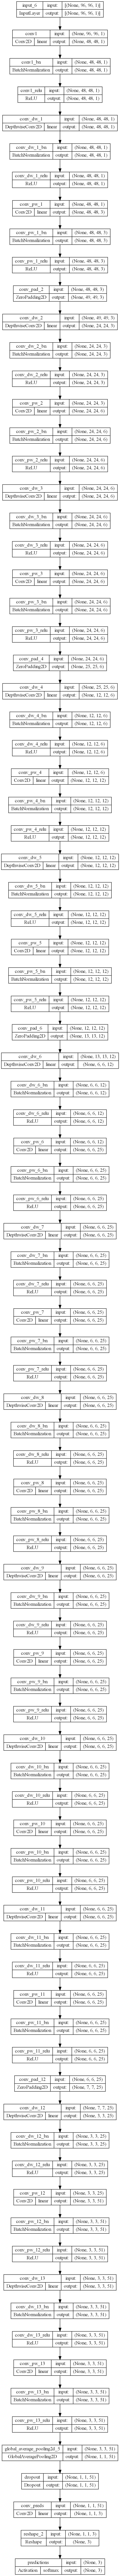

In [121]:
tf.keras.utils.plot_model(
    model,
    to_file=models_image_path,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",  # TB for vertical plot, LR for horizontal plot
    expand_nested=True,
    layer_range=None,
    dpi=200,
    show_layer_activations=True,
)

# Save the model summary


In [122]:
mltk_summary = summarize_model(model)
print(mltk_summary)


Model: "mobilenet_0.05_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 1)         9         
                                                                 
 conv1_bn (BatchNormalizatio  (None, 48, 48, 1)        4         
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 48, 48, 1)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 1)        9         
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 48, 48, 1)        4         
 ation)                                          

In [123]:
from contextlib import redirect_stdout

with open(models_summary_path, "w") as f:
    with redirect_stdout(f):
        #model.summary()
        print(mltk_summary)

In [124]:
def parse_model_summary(filepath): 
    # Parse the MLTK model summary to grab important metrics   
    with open(filepath, "r") as f:
        lines = f.readlines() # list containing lines of file
        #columns = [] # To store column names

        i = 1
        for line in lines:
            line = line.strip() # remove leading/trailing white spaces
            if line.startswith("Total params:"):
                total_params = line.split()[-1]
                total_params = int(total_params.replace(",", ""))
            elif line.startswith("Trainable params:"):
                trainable_params = line.split()[-1]
                trainable_params =  int(trainable_params.replace(",", ""))
            elif line.startswith("Non-trainable params:"):
                non_trainable_params = line.split()[-1]
                non_trainable_params = int(non_trainable_params.replace(",", ""))
            elif line.startswith("Total MACs:"):
                MMACs = line.split()[-2]
                MMACs = (float(MMACs))
            elif line.startswith("Total OPs:"):
                MFLOPs = line.split()[-2]
                MFLOPs = (float(MFLOPs))
            else:
                pass
    
    return (total_params, trainable_params, non_trainable_params, MMACs, MFLOPs)


In [125]:

total_params, trainable_params, non_trainable_params, MMACs, MFLOPs = parse_model_summary(models_summary_path)    
    

In [126]:
model_stats["M_MACs"] = MMACs
model_stats["M_FLOPs"] = MFLOPs
model_stats["total_params"] = total_params
model_stats["trainable_params"] = trainable_params
model_stats["non_trainable_params"] = non_trainable_params

# Save the model

In [127]:
model.save(models_tf_path)
models_tf_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenet_0.05_96_0.05_96_c1_o3_keras/mobilenet_0.05_96_0.05_96_c1_o3_keras.h5')

In [128]:
model_stats["model_size_kb"] = get_file_size(models_tf_path)

File size in bytes is 306756
File size in kilobytes is 299.56640625


In [129]:
reconstructed_model = keras.models.load_model(models_tf_path)

# Let's check:
# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )

# # The reconstructed model is already compiled and has retained the optimizer
# # state, so training can resume:
# reconstructed_model.fit(test_input, test_target)


# Conversion to TFLite

In [130]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter = tf.lite.TFLiteConverter.from_saved_model(models_path)
tflite_model = converter.convert()

# Save the model.
with open(models_tflite_path, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpp03v8v4a\assets


In [131]:
model_stats["tflite_model_size_kb"] = get_file_size(models_tflite_path)

File size in bytes is 59236
File size in kilobytes is 57.84765625


# Conversion to TFLite with Quantization
A representative dataset is needed for quantization

## Create representative dataset for quantization

In [132]:
data_dir = Path.cwd().parent.joinpath("lemon_dataset", "docs", "data")
dataset_path = Path.cwd().joinpath("datasets", "lemon_dataset")
dataset_path.exists()

shuffle_seed = 42


def get_lemon_quality_dataset(
    dataset_path, img_width, img_height, batch_size, normalize=True
):
    """Fetches the lemon quality dataset and prints dataset info. It normalizes the image data to range [0,1] by default.

    Args:
        dataset_path (Path): the file location of the dataset. Subfolders "train", "test", and "val" are expected.
        normalize (boolean): Normalizes the image data to range [0, 1]. Default: True

    Returns:
        (train_ds, val_ds, test_ds, class_names) (tuple(tf.datasets)): Tensorflow datasets for train, validation and test.

    """
    if dataset_path.exists():
        try:
            train_dir = dataset_path.joinpath("train")
            val_dir = dataset_path.joinpath("val")
            test_dir = dataset_path.joinpath("test")
        except:
            print(f"Please check the folder structure of {dataset_path}.")
            raise

    print("Preparing training dataset...")
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        # batch_size=1)
    )

    class_names = train_ds.class_names

    print("Preparing validation dataset...")
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        # batch_size=batch_size)
    )

    print("Preparing test dataset...")
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        # batch_size=batch_size)
    )

    # https://github.com/tensorflow/tensorflow/issues/56089

    # # Normalize the data to the range [0, 1]
    # if normalize:
    #     normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

    #     train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    #     val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
    #     test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
    # else:
    #     pass

    print(f"Class names: {class_names}")
    print(train_ds.element_spec)
    #print(f"Normalize: {normalize}")
    return (train_ds, val_ds, test_ds, class_names)

In [133]:
IMG_WIDTH = input_shape[1]
IMG_HEIGHT = input_shape[0]
BATCH_SIZE = 32

train_ds, val_ds, test_ds, labels = get_lemon_quality_dataset(
    dataset_path, IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE
)

Preparing training dataset...
Found 2021 files belonging to 3 classes.
Preparing validation dataset...
Found 252 files belonging to 3 classes.
Preparing test dataset...
Found 255 files belonging to 3 classes.
Class names: ['bad_quality', 'empty_background', 'good_quality']
(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [134]:
rescale = tf.keras.layers.Rescaling(1.0 / 255, offset=-1)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [135]:
rep_ds = train_ds.unbatch()
rep_ds

<_UnbatchDataset element_spec=(TensorSpec(shape=(96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [136]:
def representative_data_gen():
    # for input_value in train_ds.unbatch.batch(1).take(100):
    for input_value, output_value in rep_ds.batch(1).take(100):
        # Model has only one input so each data point has one element.
        print(input_value)
        yield [input_value]

In [137]:
# currently not needed, just needed for testing
# test_ds = tf.keras.utils.image_dataset_from_directory(
#     dataset_path,
#     interpolation="bilinear",
#     image_size=(IMG_WIDTH, IMG_HEIGHT),
#     # batch_size=1)
# )

# test_ds = test_ds.map(lambda x, y: (rescale(x), y))
# test_ds

## Convert model to INT8

In [138]:
# converter_INT = tf.lite.TFLiteConverter.from_keras_model(model)

# # Set the optimization flag.
# converter_INT.optimizations = [tf.lite.Optimize.DEFAULT]
# # Enforce integer only quantization
# converter_INT.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter_INT.inference_input_type = tf.int8
# converter_INT.inference_output_type = tf.int8
# # Provide a representative dataset to ensure we quantize correctly.
# # converter_INT.representative_dataset = representative_dataset(rep_ds)
# converter_INT.representative_dataset = representative_data_gen
# # converter_INT.representative_dataset = rep_ds
# model_tflite_opt = converter_INT.convert()

# # Save the model to disk
# with open(models_tflite_opt_path, "wb") as f:
#     f.write(model_tflite_opt)

In [139]:
# model_stats["tflite_INT8_model_size_kb"] = get_file_size(models_tflite_opt_path)

In [140]:
# # repr_ds = test_ds.unbatch()

# # def representative_data_gen():
# #   for i_value, o_value in repr_ds.batch(1).take(48):
# #     yield [i_value]
# converter_opt = tf.lite.TFLiteConverter.from_keras_model(model)
# #converter_opt = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
# # converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
# converter_opt.optimizations = [tf.lite.Optimize.DEFAULT]
# #converter_opt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# #converter_opt.inference_input_type = tf.int8

# tflite_model_opt = converter_opt.convert()

# # Save the model.
# with open(models_tflite_opt_path, 'wb') as f:
#   f.write(tflite_model_opt)


In [141]:
str(models_tflite_opt_path)


'i:\\tinyml\\tiny_cnn\\models\\mobilenet_0.05_96_0.05_96_c1_o3_keras\\mobilenet_0.05_96_0.05_96_c1_o3_keras_INT8.tflite'

In [142]:
csv_file_name = f"{base_model_name}_stats.csv"
csv_path = Path.cwd().joinpath(csv_file_name)
append_dict_to_csv(csv_path, model_stats)

In [143]:
# Login to W&B
wandb.login()

# Initialize a W&B run
run = wandb.init(project=f'{base_model_name}') #, group='alpha variations')

config = wandb.config
config.update(model_stats)
#wandb.log({'augmented data': augment_table})

# Finish the run
wandb.finish()

### Convert the TFLite model to C-byte array with xxd

In [ ]:
# #open("model.tflite", "wb").write(tfl_model)
# !apt-get update && apt-get -qq install xxd
# #!xxd -c 60 -i model.tflite > indoor_scene_recognition.h
# !xxd -c 60 -i i:\\tinyml\\tiny_cnn\\models\\mobilenet_0.25_96_c3\\mobilenet_0.25_96_c3_INT8.tflite' > model_INT.h
